## 📊 Dataset Exploration (Google Landmarks Dataset)

In this section, we explored the **Google Landmarks Dataset (GLDv2)**, which contains millions of images of landmarks from around the world. Each image is labeled with:

- **`id`** → Unique identifier for the image  
- **`landmark_id`** → Numerical ID assigned to the landmark  
- **`category`** → Human-readable class/category describing the landmark type  
- **`image`** → The actual image data  
- **`label`** → The landmark label mapped from `landmark_id`  

---

### ✅ Steps Performed
1. **Loaded the Dataset**  
   - Imported the dataset containing metadata for landmark images.  
   - Verified dataset structure and checked the first few rows.  

2. **Merged Landmark Names (if available)**  
   - Combined the training metadata with the `landmarks.csv` file to map `landmark_id` → landmark name.  
   - This allows us to work with *human-readable names* instead of just numerical IDs.  

3. **Visualized Samples**  
   - Displayed random sample images with their `id`, `landmark_id`, `category`, and `label`.  
   - Verified that the dataset is correctly loaded and images are accessible.  

4. **Extracted Categories**  
   - Pulled out all unique values from the `category` column.  
   - Sorted them to see the distinct landmark types represented in the dataset.  

---

### 📂 Categories
We found that the dataset includes the following unique **categories**:

- A set of human-readable classes (such as *historical_building, museum, natural_site*, etc.).  
- These categories help us better understand the **semantic grouping** of the landmarks beyond just their IDs.  

This prepares us for the next stage: **EDA & Visualization**, where we will analyze the number of images per category and check dataset balance.


In [1]:
# Basic setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import requests
from PIL import Image
from io import BytesIO

# For visualization
import seaborn as sns
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import io


## download dataset for egypt

In [2]:

!pip install -q roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 57.0 MB/s eta 0:00:00


In [3]:
# !pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="N79o2Kg5Jx1ItlvgpiNN")
project = rf.workspace("gp-j4r5m").project("augmented-iklfg")
version = project.version(1)
dataset = version.download("yolov11")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to augmented-1 in yolov11:: 100%|██████████| 27764/27764 [00:08<00:00, 3311.62it/s]


In [4]:
import os
import glob
import collections
import shutil
from sklearn.model_selection import train_test_split

In [5]:
def get_top_classes(dataset_path, top_n=35):




    label_files = glob.glob(os.path.join(dataset_path,"**", "labels", "*.txt"), recursive=True)

    class_counts = collections.Counter()
    for lf in label_files:
        with open(lf, "r") as f:
            for line in f:
                if line.strip():
                    cid = int(line.split()[0])
                    class_counts[cid] += 1
    return [cid for cid, _ in class_counts.most_common(top_n)]

In [6]:
def collect_class_subset(dataset_path, selected_classes):
    all_images, all_labels = [], []



    label_files = glob.glob(os.path.join(dataset_path,"**", "labels", "*.txt"), recursive=True)


    for lf in label_files:
        with open(lf, "r") as f:
            lines = f.readlines()
            if not lines:
                continue
            cid = int(lines[0].split()[0])
            if cid in selected_classes:
                base = os.path.splitext(os.path.basename(lf))[0]


                img_candidates = glob.glob(os.path.join(dataset_path, "**", "images", base + ".*"), recursive=True)

                # img_candidates = glob.glob(os.path.join(dataset_path, "images", "**", base + ".*"), recursive=True)
                if img_candidates:
                    all_images.append(img_candidates[0])
                    all_labels.append(lf)
    return all_images, all_labels

In [7]:
def merge_datasets(egypt_path,output_path, top_n=35):
    # 1) احسب أعلى 20 من كل واحدة
    top20_egypt = get_top_classes(egypt_path, top_n=top_n)
    print("📌 Top 20 Egypt:", top20_egypt)

    # 2) جمع الصور والليبلز
    imgs_egypt, lbls_egypt = collect_class_subset(egypt_path, top20_egypt)

    all_images = imgs_egypt
    all_labels = lbls_egypt

    print(f"📊 Collected {len(all_images)} images total")

    # 3) Split train/test
    train_imgs, test_imgs, train_lbls, test_lbls = train_test_split(
        all_images, all_labels, test_size=0.2, random_state=42,shuffle=True
    )

    # 4) أنشئ المجلدات
    for split in ["train", "test"]:
        os.makedirs(os.path.join(output_path, "images", split), exist_ok=True)
        os.makedirs(os.path.join(output_path, "labels", split), exist_ok=True)

    # 5) نسخ train
    for img, lbl in zip(train_imgs, train_lbls):
        shutil.copy(img, os.path.join(output_path, "images", "train", os.path.basename(img)))
        shutil.copy(lbl, os.path.join(output_path, "labels", "train", os.path.basename(lbl)))

    # 6) نسخ test
    for img, lbl in zip(test_imgs, test_lbls):
        shutil.copy(img, os.path.join(output_path, "images", "test", os.path.basename(img)))
        shutil.copy(lbl, os.path.join(output_path, "labels", "test", os.path.basename(lbl)))

    print(f"✅ Done! {len(train_imgs)} train + {len(test_imgs)} test saved in {output_path}")


In [8]:
# ---------- تنفيذ ----------
egypt_path = "/content/augmented-1"
output_path = "/content/Merged_Top20_YOLO"

merge_datasets(egypt_path, output_path, top_n=35)

📌 Top 20 Egypt: [19, 53, 24, 36, 5, 44, 41, 2, 82, 72, 34, 32, 0, 80, 62, 70, 56, 27, 69, 1, 29, 16, 66, 14, 71, 60, 23, 46, 15, 42, 13, 55, 64, 78, 38]
📊 Collected 10646 images total
✅ Done! 8516 train + 2130 test saved in /content/Merged_Top20_YOLO


In [9]:
import os
import glob

# number of images and classes in Merged_Top20_YOLO Dataset

dataset_path = "/content/Merged_Top20_YOLO"

img_files = glob.glob(os.path.join(dataset_path, "images", "**", "*.jpg"), recursive=True)
img_files += glob.glob(os.path.join(dataset_path, "images", "**", "*.png"), recursive=True)
num_images = len(img_files)

class_ids = set()
label_files = glob.glob(os.path.join(dataset_path, "labels", "**", "*.txt"), recursive=True)

for lf in label_files:
    with open(lf, "r") as f:
        for line in f:
            if line.strip():
                cid = int(line.split()[0])
                class_ids.add(cid)

num_classes = len(class_ids)

print(f"number of images {num_images}")
print(f"number of classes: {num_classes}")
# print(f"IDs: {sorted(class_ids)}")


number of images 10646
number of classes: 35


In [10]:
import os
import glob

# الكلاسات المختارة
# selected_classes = [19, 53, 24, 36, 5, 44, 41, 2, 82, 72, 34, 32, 0, 80, 62, 70, 56, 27, 69, 1, 29, 16, 66, 14, 71, 60, 23, 46, 15, 42, 13, 55, 64, 78, 38]
#29, 16, 66, 14, 71, 60, 23, 46, 15, 42, 13, 55, 64, 78, 38
selected_classes = [19, 53, 24, 36, 5, 44, 41, 2, 82, 72, 34, 32, 0, 80, 62, 70, 56, 27, 69, 1, 29, 16, 66, 14, 71, 60, 23, 46, 15, 42, 13, 55, 64, 78, 38]


# اعمل mapping جديد (0 → n-1)
class_mapping = {old_id: new_id for new_id, old_id in enumerate(selected_classes)}

print("📌 Class Mapping:")
print(class_mapping)

# مسار الفولدر الجديد
dataset_path = "/content/Merged_Top20_YOLO"

# عدّل كل label files
label_files = glob.glob(os.path.join(dataset_path, "labels", "**", "*.txt"), recursive=True)

for lf in label_files:
    new_lines = []
    with open(lf, "r") as f:
        for line in f:
            parts = line.strip().split()
            if not parts:
                continue
            old_cid = int(parts[0])
            if old_cid in class_mapping:   # نعدّل لو الكلاس مختار
                parts[0] = str(class_mapping[old_cid])
                new_lines.append(" ".join(parts))
    # overwrite الملف
    with open(lf, "w") as f:
        f.write("\n".join(new_lines))

print("✅ Done! كل الكلاسات اتعملها re-index من 0 →", len(selected_classes)-1)


📌 Class Mapping:
{19: 0, 53: 1, 24: 2, 36: 3, 5: 4, 44: 5, 41: 6, 2: 7, 82: 8, 72: 9, 34: 10, 32: 11, 0: 12, 80: 13, 62: 14, 70: 15, 56: 16, 27: 17, 69: 18, 1: 19, 29: 20, 16: 21, 66: 22, 14: 23, 71: 24, 60: 25, 23: 26, 46: 27, 15: 28, 42: 29, 13: 30, 55: 31, 64: 32, 78: 33, 38: 34}
✅ Done! كل الكلاسات اتعملها re-index من 0 → 34


## Model

In [11]:
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.4 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [13]:
yaml_content = """
path : /content/Merged_Top20_YOLO
train : /content/Merged_Top20_YOLO/images/train
val : /content/Merged_Top20_YOLO/images/test

names:
  0: Colossoi of Memnon
  1: Sphinx
  2: Great Pyramids of Giza
  3: Mask of Tutankhamun
  4: Bent Pyramid of King Sneferu
  5: Pyramid of Djoser
  6: Nefertiti
  7: Amenhotep III and Tiye
  8: bust of Ramesses II
  9: Statue of King Zoser
  10: King Thutmose III
  11: Isis with her child
  12: Akhenaten
  13: Statue of Tutankhamun
  14: Statue of Ankhesenamun
  15: Statue of King Ramses II Luxor Temple
  16: Standing Statue of King Ramses II
  17: Hatshepsut face
  18: Statue of King Ramses II Grand Egyptian Museum
  19: Amenhotep III
  20: Head Statue of Amenhotep iii
  21: Colossal Statue of Queen Hatshepsut
  22: Statue of Khafre
  23: Colossal Statue of King Senwosret IlI
  24: Statue of King Sety Il Holding Standards
  25: Statue of Amenmhat I
  26: Granite Statue of Tutankhamun
  27: Seated Statue of Amenhotep III
  28: Colossal Statue of Middle Kingdom King
  29: Obelsik Tip of Hatshepsut
  30: Colossal Statue of Hormoheb
  31: Sphinx of Kings Ramesses ll - Merenptah
  32: Statue of God Ptah Ramesses ll Goddess Sekhmet
  33: Statue of Snefru
  34: Menkaure Statue
"""

with open('/content/Merged_Top20_YOLO/data.yaml', 'w') as f:
    f.write(yaml_content)

In [14]:
model = YOLO('/content/last (2).pt')

In [ ]:
result2 = model.predict(source='/content/Merged_Top20_YOLO/images/train/1_0-3-_jpg.rf.8752f5e14a64154e0a6d738a504b82fe.jpg',conf=0.25,device=[-1,-1],save=True)

WARNING ⚠️ Failed to initialize pynvml, GPU stats disabled: NVML Shared Library Not Found
Searching for 2 idle GPUs with free memory >= 20.0% and free utilization >= 0.0%...
WARNING ⚠️ NVML stats unavailable.

image 1/1 /content/Merged_Top20_YOLO/images/train/1_0-3-_jpg.rf.8752f5e14a64154e0a6d738a504b82fe.jpg: 640x640 2 Great Pyramids of Gizas, 390.0ms
Speed: 20.0ms preprocess, 390.0ms inference, 33.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


In [ ]:
from IPython.display import Image

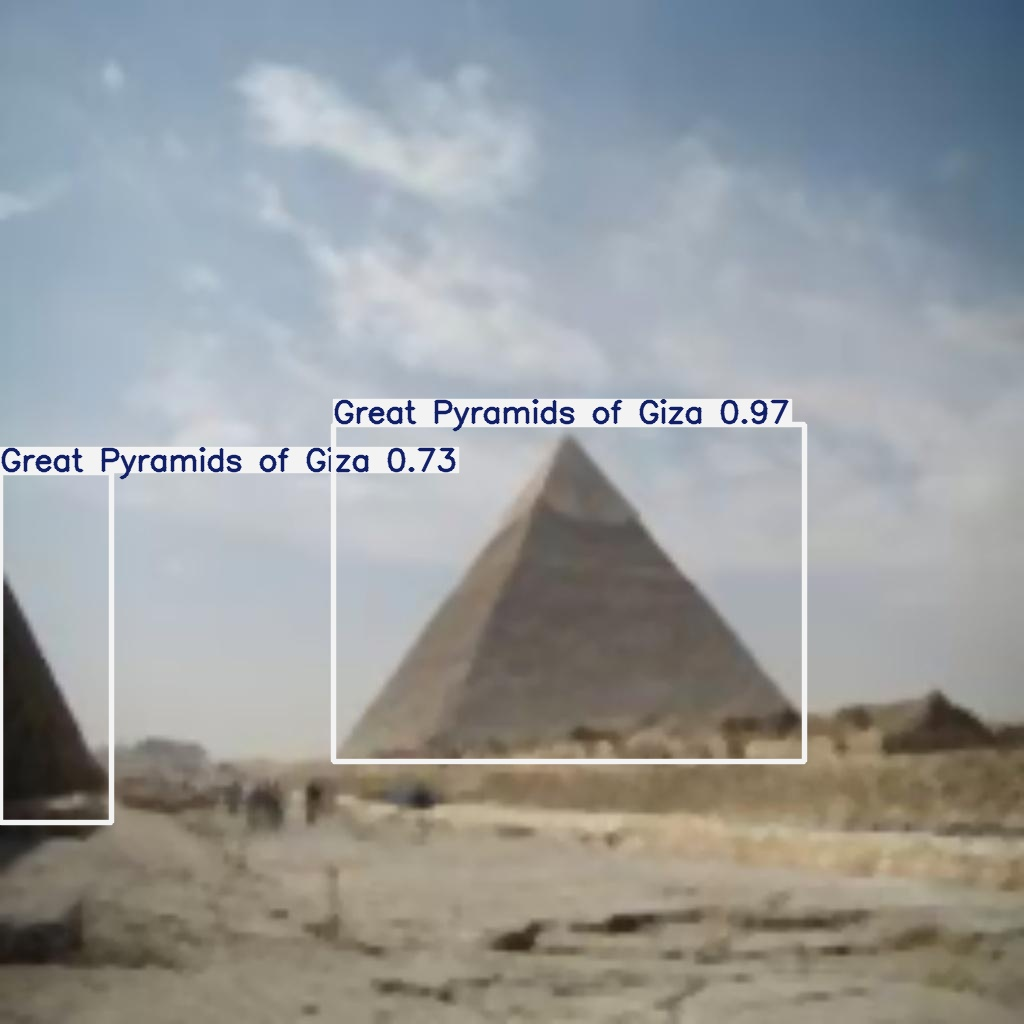

In [ ]:
Image('/content/runs/detect/predict/1_0-3-_jpg.rf.8752f5e14a64154e0a6d738a504b82fe.jpg',width=600)

In [ ]:
import os
from ultralytics import YOLO
from PIL import Image


def crop_and_save(model, images_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    for img_name in os.listdir(images_dir):
        if not img_name.lower().endswith((".jpg", ".png", ".jpeg")):
            continue

        img_path = os.path.join(images_dir, img_name)

        # Run YOLO inference
        results = model(img_path)

        
        img = Image.open(img_path).convert("RGB")

        
        for i, box in enumerate(results[0].boxes):
            cls_id = int(box.cls[0].item())   # class id
            x_min, y_min, x_max, y_max = box.xyxy[0].tolist()
            x_min, y_min, x_max, y_max = map(int, [x_min, y_min, x_max, y_max])

            # crop
            crop = img.crop((x_min, y_min, x_max, y_max))

            
            class_dir = os.path.join(output_dir, str(cls_id))
            os.makedirs(class_dir, exist_ok=True)

            
            crop.save(os.path.join(class_dir, f"{img_name.replace('.jpg','')}_{i}.jpg"))

    print(f"✅ Cropping done for {images_dir} → saved to {output_dir}")



crop_and_save(model, "/content/Merged_Top20_YOLO/images/train", "egypt_cropped/train")
crop_and_save(model, "/content/Merged_Top20_YOLO/images/test", "egypt_cropped/test")


Streaming output truncated to the last 5000 lines.
Speed: 4.5ms preprocess, 10.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/Merged_Top20_YOLO/images/test/1_30_jpg.rf.2ae8dc505eac8a8e8596586d5ede559d.jpg: 640x640 1 Sphinx of Kings Ramesses ll - Merenptah, 10.3ms
Speed: 4.1ms preprocess, 10.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/Merged_Top20_YOLO/images/test/3_7_jpg.rf.92c5a3dd8da506e59554db3338687642.jpg: 640x640 1 Nefertiti, 11.8ms
Speed: 4.2ms preprocess, 11.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/Merged_Top20_YOLO/images/test/2_7-1-_jpg.rf.92df06ca77ffe85666799c591f40bd02.jpg: 640x640 1 Great Pyramids of Giza, 11.2ms
Speed: 4.4ms preprocess, 11.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/Merged_Top20_YOLO/images/test/1_12_jpg.rf.913df4a0f7499e50715c2e144824a38c.jpg: 640x640 1 Amenhotep III and Tiye,

In [23]:
!zip -r /content/Merged_Top20_YOLO/images.zip /content/Merged_Top20_YOLO/images

Streaming output truncated to the last 5000 lines.
  adding: content/Merged_Top20_YOLO/images/train/1_74_jpg.rf.2487f1853457fb2d66ff393e71bf8408.jpg (deflated 1%)
  adding: content/Merged_Top20_YOLO/images/train/3_20250414_143242_jpg.rf.dbcc128205bc863a3fe1c82df1cce66b.jpg (deflated 1%)
  adding: content/Merged_Top20_YOLO/images/train/2_IMG_1101_jpg.rf.7c105fc13745c40b7d87561cf8d37ce0.jpg (deflated 0%)
  adding: content/Merged_Top20_YOLO/images/train/2_download-13-_jpg.rf.79d0515a81cc49f0f44d65cae17f9f85.jpg (deflated 1%)
  adding: content/Merged_Top20_YOLO/images/train/4_IMG_20250425_142934_jpg.rf.8431fde8a80f6d3cbedd841d6d027650.jpg (deflated 1%)
  adding: content/Merged_Top20_YOLO/images/train/3_23_jpg.rf.de7cb975ead16779d53e052f1cb2956e.jpg (deflated 5%)
  adding: content/Merged_Top20_YOLO/images/train/4_51_jpg.rf.733ac314ae9d14668737950810301b71.jpg (deflated 6%)
  adding: content/Merged_Top20_YOLO/images/train/1_th-3-_jpeg.rf.12108cf11211d8377fe7b6226419e843.jpg (deflated 2%)
  a

In [24]:
from google.colab import files
files.download("/content/Merged_Top20_YOLO/images.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models

# Define the paths to the training and validation data
train_data_dir = 'egypt_cropped/train'
val_data_dir = 'egypt_cropped/test'

# Define image size and batch size
image_size = 224 # Standard for many pre-trained models
batch_size = 32

# Define data transformations for training and validation
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet standards
])

val_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = datasets.ImageFolder(train_data_dir, train_transforms)
val_dataset = datasets.ImageFolder(val_data_dir, val_transforms)

# Create dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Load a pre-trained model (e.g., ResNet18) and modify the final layer
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 35) # Assuming 35 classes

# Print model structure to verify the change
print(model)

print("✅ Training environment set up: Datasets, DataLoaders, and Model loaded.")

In [19]:
from google.colab import files
criterion = nn.CrossEntropyLoss()


In [ ]:
# 1. Determine the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Define the loss function
criterion = nn.CrossEntropyLoss()

# 3. Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. Move the model to the device
model.to(device)

# 5. Iterate through epochs
epochs = 14# Define the number of epochs
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    print("-" * 10)

    # Training phase
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad() # Zero the gradients

        outputs = model(inputs) # Forward pass
        loss = criterion(outputs, labels) # Calculate loss

        loss.backward() # Backward pass
        optimizer.step() # Update weights

        running_loss += loss.item() * inputs.size(0)

    if (epoch+1) % 2 == 0 or epoch < epochs:
        # Save checkpoint
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),

        }

        checkpoint_path = f"{checkpoint_dir}/checkpoint_epoch_{epoch + 1}.pth"
        torch.save(checkpoint, checkpoint_path)

        
        zip_path = f"{checkpoint_path}.zip"
        !zip -j "$zip_path" "$checkpoint_path"
        files.download(zip_path)

    epoch_loss = running_loss / len(train_dataset)
    print(f"Train Loss: {epoch_loss:.4f}")

    # (Optional) Validation phase
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad(): # Disable gradient calculation
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(val_dataset)
    accuracy = correct_predictions / total_predictions
    print(f"Val Loss: {epoch_loss:.4f}, Val Accuracy: {accuracy:.4f}")

print("✅ Training finished.")

Using device: cuda
Epoch 1/14
----------
updating: checkpoint_epoch_1.pth (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Train Loss: 1.2623
Val Loss: 0.6958, Val Accuracy: 0.7925
Epoch 2/14
----------
updating: checkpoint_epoch_2.pth (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Train Loss: 0.7149
Val Loss: 0.3271, Val Accuracy: 0.9123
Epoch 3/14
----------
updating: checkpoint_epoch_3.pth (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Train Loss: 0.5185
Val Loss: 0.3692, Val Accuracy: 0.8906
Epoch 4/14
----------
  adding: checkpoint_epoch_4.pth (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Train Loss: 0.4907
Val Loss: 0.2361, Val Accuracy: 0.9275
Epoch 5/14
----------
  adding: checkpoint_epoch_5.pth (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Train Loss: 0.4056
Val Loss: 0.2350, Val Accuracy: 0.9224
Epoch 6/14
----------
  adding: checkpoint_epoch_6.pth (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Train Loss: 0.3996
Val Loss: 0.2001, Val Accuracy: 0.9438
Epoch 7/14
----------
  adding: checkpoint_epoch_7.pth (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Train Loss: 0.3680
Val Loss: 0.1683, Val Accuracy: 0.9461
Epoch 8/14
----------
  adding: checkpoint_epoch_8.pth (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Train Loss: 0.3378
Val Loss: 0.1050, Val Accuracy: 0.9728
Epoch 9/14
----------
  adding: checkpoint_epoch_9.pth (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Train Loss: 0.2852
Val Loss: 0.1185, Val Accuracy: 0.9655
Epoch 10/14
----------
  adding: checkpoint_epoch_10.pth (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Train Loss: 0.2965
Val Loss: 0.1539, Val Accuracy: 0.9538
Epoch 11/14
----------
  adding: checkpoint_epoch_11.pth (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Train Loss: 0.2852
Val Loss: 0.1094, Val Accuracy: 0.9694
Epoch 12/14
----------
  adding: checkpoint_epoch_12.pth (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Train Loss: 0.2628
Val Loss: 0.1250, Val Accuracy: 0.9659
Epoch 13/14
----------
  adding: checkpoint_epoch_13.pth (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Train Loss: 0.2689
Val Loss: 0.1138, Val Accuracy: 0.9721
Epoch 14/14
----------
  adding: checkpoint_epoch_14.pth (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Train Loss: 0.2533
Val Loss: 0.1409, Val Accuracy: 0.9616
✅ Training finished.


## Save Model

In [ ]:
# Define the path to save the model
model_save_path = "/content/egyptian_landmarks_classification_model.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

print(f"✅ Model saved successfully to {model_save_path}")

✅ Model saved successfully to /content/egyptian_landmarks_classification_model.pth


## Load Model

In [17]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the saved model weights
model_save_path = "/content/egyptian_landmarks_classification_model.pth"

# Instantiate the same model architecture used for training (ResNet18)
# Make sure the number of output features matches the number of classes (35)
reloaded_model = models.resnet18(pretrained=False) # No need to load ImageNet weights again
num_ftrs = reloaded_model.fc.in_features
reloaded_model.fc = nn.Linear(num_ftrs, 35) # Set output layer for 35 classes

# Load the saved state dictionary into the model
reloaded_model.load_state_dict(torch.load(model_save_path, map_location=device))

# Move the model to the device
reloaded_model.to(device)

# Set the model to evaluation mode
reloaded_model.eval()

print("✅ Model reloaded successfully and ready for testing!")

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.


✅ Model reloaded successfully and ready for testing!


## Test model

In [ ]:
with torch.no_grad(): # Disable gradient calculation
    for inputs, labels in val_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = reloaded_model(inputs)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

epoch_loss = running_loss / len(val_dataset)
accuracy = correct_predictions / total_predictions
print(f"Val Loss: {epoch_loss:.4f}, Val Accuracy: {accuracy:.4f}")

Val Loss: 0.2818, Val Accuracy: 0.9616


In [ ]:
with torch.no_grad(): # Disable gradient calculation
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = reloaded_model(inputs)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

epoch_loss = running_loss / len(val_dataset)
accuracy = correct_predictions / total_predictions
print(f"Val Loss: {epoch_loss:.4f}, Val Accuracy: {accuracy:.4f}")

Val Loss: 1.2601, Val Accuracy: 0.9359


## Test Model after upload from device

In [21]:
running_loss = 0.0
correct_predictions = 0
total_predictions = 0

with torch.no_grad(): # Disable gradient calculation
    for inputs, labels in val_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = reloaded_model(inputs)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

epoch_loss = running_loss / len(val_dataset)
accuracy = correct_predictions / total_predictions
print(f"Val Loss: {epoch_loss:.4f}, Val Accuracy: {accuracy:.4f}")

Val Loss: 0.1502, Val Accuracy: 0.9582


In [22]:
running_loss = 0.0
correct_predictions = 0
total_predictions = 0
with torch.no_grad(): # Disable gradient calculation
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = reloaded_model(inputs)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

epoch_loss = running_loss / len(val_dataset)
accuracy = correct_predictions / total_predictions
print(f"Val Loss: {epoch_loss:.4f}, Val Accuracy: {accuracy:.4f}")

Val Loss: 1.0371, Val Accuracy: 0.9248
